In [1]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

In [3]:
test_dataset = KittiGraphDataset(basedir, "09", graph_length=25)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  world_positions = []
  world_rotations = []

  for i, prediction in enumerate(predictions):
    if i == 0:
      world_positions.append(prediction["position"])
      world_rotations.append(prediction["rotation"])
    else:
      world_positions.append(world_positions[i-1] + prediction["position"])
      # now, rotations are in quaternion form so use appropriate function
      world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

In [6]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]

    rot = R.from_quat(rot)
    return {
        "position": pos,
        "rotation": rot,
    }

In [18]:
checkpoint = torch.load("./models/E/model_E_40.pth")

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [19]:
SELECTED_IDX = 1

predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch)
        predicted_poses.append(output.cpu().numpy()[SELECTED_IDX])
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])

100%|██████████| 1566/1566 [00:05<00:00, 262.49it/s]


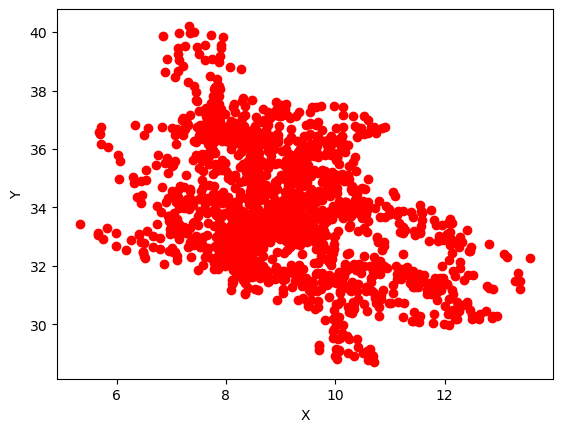

In [20]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

for pose in predicted_poses_e:
  ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

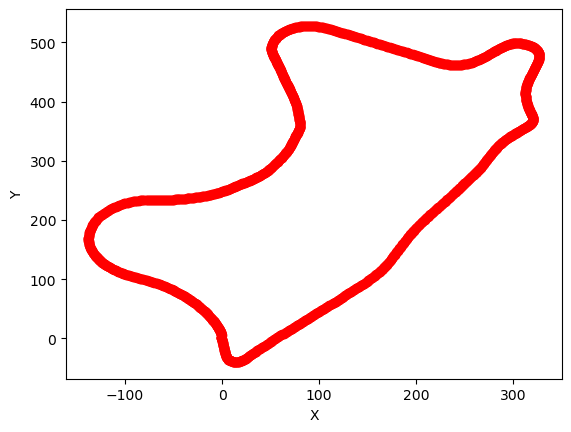

In [9]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

Predicted poses:
[{'position': array([ 9.111266, -5.378771, 31.747906], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb053f40b70>}, {'position': array([ 9.031664 , -5.6548023, 31.819317 ], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb08ffc1980>}, {'position': array([ 9.105636 , -5.5338745, 31.74069  ], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb08ffc1a70>}, {'position': array([ 9.221326, -5.497309, 31.838713], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb08ffc1b60>}, {'position': array([ 9.182422 , -5.3460875, 31.808716 ], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb08ffc1c50>}, {'position': array([ 9.44064  , -5.7032523, 31.530876 ], dtype=float32), 'rotation': <scipy.spatial.transform._rotation.Rotation object at 0x7fb08ffc1d40>}, {'position': array([ 9.348419, -5.466578, 31.6

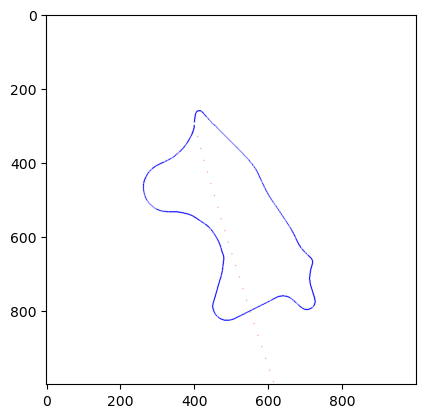

In [22]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

print("Predicted poses:")
print(predicted_poses_e)

trajectory_image = np.zeros((1000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(predicted_poses_e)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 400
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 400
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)
    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)


trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)